# Deformation of an elastic joint

We solve here numerically with the finite element method the example of the elastic joint of the TD 3 on the energy methods and the variational approximations.

In [2]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import dolfinx
import ufl
import dolfinx.fem.petsc 

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType


## Define the linear problem and solve
Let us generate a simple mesh. More complex and realistic meshes can be generated with [gmsh](http://gmsh.info/.)


In [3]:
Lx = 3.0
Ly = 1.
nu = 1./3.
E = 1.
lambda_ = nu * E / ((1-2*nu) * (1+nu))
mu = E/(2*(1+nu))
u_d = -1.0 * Lx

mesh_size = 0.05
import gmsh
from dolfinx.io import gmshio
from mpi4py import MPI

gmsh.initialize()
gdim = 2
gmsh.option.setNumber("General.Verbosity", 1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",mesh_size)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",mesh_size)
rect = gmsh.model.occ.addRectangle(0, 0, 0, Lx, Ly)
gmsh.model.occ.synchronize()
gmsh.option.setNumber("Mesh.Algorithm", 5)
gmsh.model.addPhysicalGroup(gdim, [rect], 1)
# gmsh set verbosity
gmsh.model.mesh.generate(gdim)
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=gdim)
#domain = dolfinx.mesh.create_rectangle(MPI.COMM_WORLD, [np.array([0,0]), np.array([L, W])],
#                  [int(L/W)*ndiv,ndiv], cell_type=dolfinx.mesh.CellType.triangle)
gmsh.finalize()
domain_dimension = domain.topology.dim
facet_dimension = domain.topology.dim - 1
print(f"We have a {domain_dimension}-d mesh with {facet_dimension}-d boundary")

V = dolfinx.fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

def left(x):
    return np.isclose(x[0], 0.0)

left_facets = dolfinx.mesh.locate_entities_boundary(domain, facet_dimension, left)
left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_dimension, left_facets)
bc_value_left = np.array([0,0],dtype=ScalarType)
bc_left = dolfinx.fem.dirichletbc(bc_value_left, left_dofs, V)

def right(x):
    return np.isclose(x[0], Lx)
right_facets = dolfinx.mesh.locate_entities_boundary(domain, facet_dimension, right)
right_dofs = dolfinx.fem.locate_dofs_topological(V, facet_dimension, right_facets)
bc_value_right = np.array([u_d,0],dtype=ScalarType)
bc_right = dolfinx.fem.dirichletbc(bc_value_right, right_dofs, V)
bcs = [bc_left, bc_right]

mt = dolfinx.mesh.meshtags(domain, facet_dimension, right_facets, 1)
ds = ufl.Measure("ds", subdomain_data=mt, domain=domain)
dx = ufl.Measure("dx", domain=domain)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

x = ufl.SpatialCoordinate(domain)

def eps(u):
    return ufl.sym(ufl.grad(u))
    
def sigma(eps):
    return lambda_ * ufl.tr(eps) * ufl.Identity(2) + 2 * mu * eps

def a(u,v):
    """The bilinear form of the weak formulation"""
    return ufl.inner(sigma(eps(u)), eps(v)) * dx

def L(v): 
    """The linear form of the weak formulation"""
    # Volume force
    b = dolfinx.fem.Constant(domain,ScalarType((0, 0)))

    # Surface force on the top
    f = ufl.as_vector([0, 0])
    #return ufl.dot(b, v) * dx + ufl.dot(f, v) * ds(1)    
    return ufl.inner(b, v) * dx + ufl.dot(f, v) * ds

problem = dolfinx.fem.petsc.LinearProblem(a(u,v), L(v), bcs=bcs, 
                                    petsc_options={"ksp_type": "gmres", "pc_type": "gamg"})
uh = problem.solve()
uh.name = "displacement"


We have a 2-d mesh with 1-d boundary


## Postprocessing

We can easily calculate the potential energy

In [4]:

elastic_energy = dolfinx.fem.assemble_scalar(dolfinx.fem.form(0.5 * a(uh, uh)))
print(f"The elastic energy energy is {elastic_energy:2.3f}")

external_work = dolfinx.fem.assemble_scalar(dolfinx.fem.form(L(uh)))
print(f"The external work is {external_work:2.3f}")

The elastic energy energy is 1.726
The external work is 0.000


We can calculate the global stiffeness of the joint and compare with the classical estimates obtained assuming either homogenous deformation ($k_{max}$) or homogenous stress ($k_{min}$)

In [5]:
k_equivalent = elastic_energy * 2 / u_d **2 
print(f'The equivalent stiffness obtained <ith the FE solution is {k_equivalent:2.3f}')

k_min = 2 *E * (Ly/2) /((1-nu**2)*Lx) 
k_max = 2 *E * (Ly/2) /(Lx) *(1-nu)/((1-2*nu)*(1+nu)) 
print(f'The rough estimation is k_min={k_min:2.3f}, k_max={k_max:2.3f}')

The equivalent stiffness obtained <ith the FE solution is 0.384
The rough estimation is k_min=0.375, k_max=0.500


We can save the results to a file, that we can open with `paraview` (https://www.paraview.org/)

In [6]:
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo.xdmf", "w") as file:
    file.write_mesh(uh.function_space.mesh)
    file.write_function(uh)

Let us plot the solution using `pyvista`, see
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/v0.5.0/python/demos/demo_pyvista.html

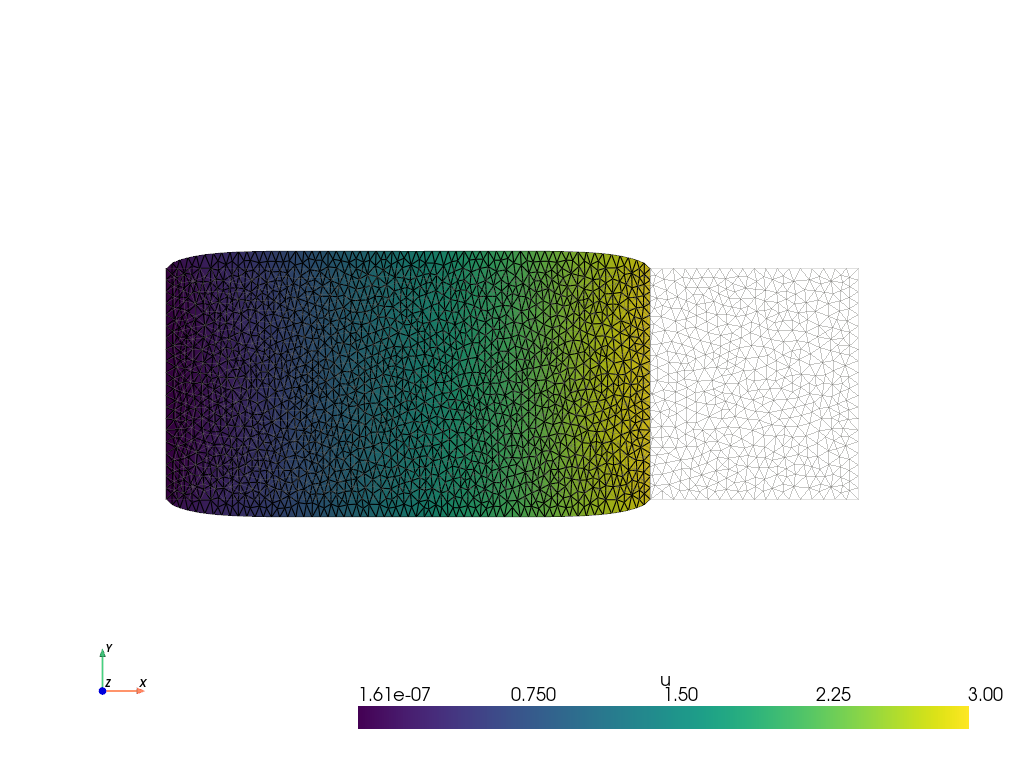

In [7]:
import vtk 
import pyvista
pyvista.xvfb.start_xvfb()
pyvista.set_jupyter_backend("static") #

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = dolfinx.plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
actor_0 = p.add_mesh(grid, style="wireframe", color="gray",opacity=0.2,)
# Attach vector values to grid and warp grid by vector
values = np.zeros((geometry.shape[0], 3))
values[:, :len(uh)] = uh.x.array.reshape(geometry.shape[0], len(uh))
grid["u"] = values
#actor_0 = p.add_mesh(grid, style="surface", color="gray",opacity=0.9)
warped = grid.warp_by_vector("u", factor=0.3)
actor_1 = p.add_mesh(warped, show_edges=True,show_scalar_bar=True)
p.show_axes()
p.view_xy()
p.show()

## Stress computation

We calculate here the Von Mises stress by interpolating the corresponding ufl expression, see https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html#stress-computation

In [8]:
stress = sigma(eps(uh))

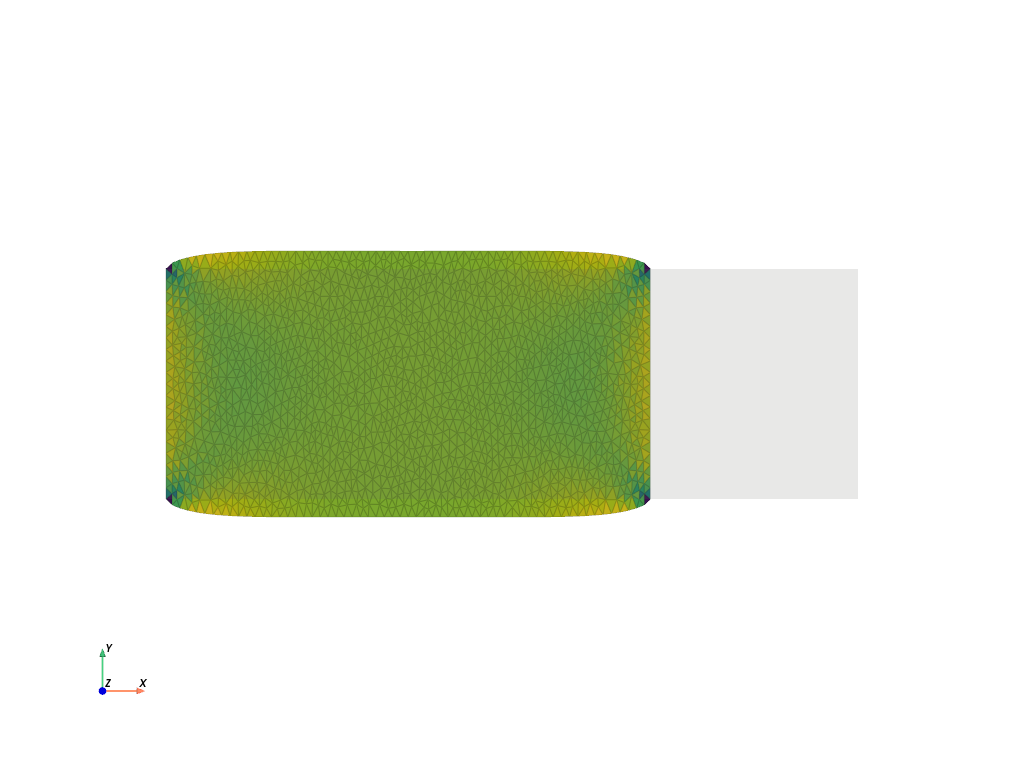

In [9]:
V_stress_scalar = dolfinx.fem.functionspace(domain, ("DG", 0))

stress_xx_function = dolfinx.fem.Function(V_stress_scalar, name="sigmaxx")
stress_xx_expr = dolfinx.fem.Expression(stress[0,0], V_stress_scalar.element.interpolation_points())
stress_xx_function.interpolate(stress_xx_expr)

p = pyvista.Plotter()
actor_0 = p.add_mesh(grid, style="surface", color="gray",opacity=0.15,)

field_label = r"$\sigma_{xx}$"
warped.cell_data[field_label] = stress_xx_function.x.array
warped.set_active_scalars(field_label)
p.add_mesh(warped, show_scalar_bar=False, clim=[-2, -1],show_edges=True,edge_opacity=.2,
           scalar_bar_args={'title': field_label, 'vertical': False, #'height': 0.5, 'width': 0.05, 
                            #'position_x': .9, 'position_y': 0.25
                            }
           )
p.show_axes()
p.view_xy()
p.show()

Let us now wrap up the finite element solver in a function and plot the estimate as a function of the aspect ratio of the joint and compare with the analytical estimates.

In [10]:
def k_equivalent_fem(Lx=0.1,nu=1./3.,mesh_size=0.05):
    """Compute the equivalent stiffness matrix from the displacement uh"""
    Ly = 1.
    E = 1.
    lambda_ = nu * E / ((1-2*nu) * (1+nu))
    mu = E/(2*(1+nu))
    u_d = -1.
    
    gmsh.initialize()
    gdim = 2
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin",mesh_size)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax",mesh_size)
    rect = gmsh.model.occ.addRectangle(0, 0, 0, Lx, Ly)
    gmsh.model.occ.synchronize()
    gmsh.option.setNumber("Mesh.Algorithm", 5)
    gmsh.model.addPhysicalGroup(gdim, [rect], 1)
    gmsh.option.setNumber("General.Verbosity", 1)

    gmsh.model.mesh.generate(gdim)
    
    # set gmsh verbosity level
    gmsh.option.setNumber("General.Verbosity", 0)
    gmsh.option.setNumber("General.Terminal", 0)
    domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=gdim)
    #domain = dolfinx.mesh.create_rectangle(MPI.COMM_WORLD, [np.array([0,0]), np.array([L, W])],
    #                  [int(L/W)*ndiv,ndiv], cell_type=dolfinx.mesh.CellType.triangle)
    gmsh.finalize()
    domain_dimension = domain.topology.dim
    facet_dimension = domain.topology.dim - 1

    V = dolfinx.fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))
    
    def left(x):
        return np.isclose(x[0], 0.0)

    left_facets = dolfinx.mesh.locate_entities_boundary(domain, facet_dimension, left)
    left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_dimension, left_facets)
    bc_value_left = np.array([0,0],dtype=ScalarType)
    bc_left = dolfinx.fem.dirichletbc(bc_value_left, left_dofs, V)

    def right(x):
        return np.isclose(x[0], Lx)
    
    right_facets = dolfinx.mesh.locate_entities_boundary(domain, facet_dimension, right)
    right_dofs = dolfinx.fem.locate_dofs_topological(V, facet_dimension, right_facets)
    bc_value_right = np.array([u_d,0],dtype=ScalarType)
    bc_right = dolfinx.fem.dirichletbc(bc_value_right, right_dofs, V)
    bcs = [bc_left, bc_right]

    mt = dolfinx.mesh.meshtags(domain, facet_dimension, right_facets, 1)
    ds = ufl.Measure("ds", subdomain_data=mt, domain=domain)
    dx = ufl.Measure("dx", domain=domain)

    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    def eps(u):
        return ufl.sym(ufl.grad(u))

    def sigma(eps):
        return lambda_ * ufl.tr(eps) * ufl.Identity(2) + 2 * mu * eps

    def a(u,v):
        """The bilinear form of the weak formulation"""
        return ufl.inner(sigma(eps(u)), eps(v)) * dx

    def L(v): 
        """The linear form of the weak formulation"""
        # Volume force
        b = dolfinx.fem.Constant(domain,ScalarType((0, 0)))

        # Surface force on the top
        f = ufl.as_vector([0, 0])
        #return ufl.dot(b, v) * dx + ufl.dot(f, v) * ds(1)    
        return ufl.inner(b, v) * dx + ufl.dot(f, v) * ds

    problem = dolfinx.fem.petsc.LinearProblem(a(u,v), L(v), bcs=bcs, 
                                        petsc_options={"ksp_type": "gmres", "pc_type": "gamg"})
    uh = problem.solve()
    uh.name = "displacement"
    elastic_energy = dolfinx.fem.assemble_scalar(dolfinx.fem.form(0.5 * a(uh, uh)))
    k_equivalent = elastic_energy * 2 / u_d **2
    # Calculate upper and lower bounds for k_equivalent
    k_min = 2 *E * (Ly/2) /((1-nu**2)*Lx) 
    k_max = 2 *E * (Ly/2) /(Lx) *(1-nu)/((1-2*nu)*(1+nu)) 
    print(f"Lx: {Lx:2.3f}, The elastic energy is {elastic_energy:2.3f}, equivalent stiffness is {k_equivalent:2.3f}, k_lower: {k_min:2.3f}, k_upper: {k_max:2.3f}") 

    return  k_equivalent, k_min, k_max

k_equivalent_fem(Lx=1.0,nu=1./3.,mesh_size=0.05)

Ls = np.linspace(.1,3,20)
ks = np.array([k_equivalent_fem(Lx,nu=1./3.,mesh_size=min([0.1,Lx/10])) for Lx in Ls])

# plot the results


Lx: 1.000, The elastic energy is 0.604, equivalent stiffness is 1.208, k_lower: 1.125, k_upper: 1.500
Lx: 0.100, The elastic energy is 7.285, equivalent stiffness is 14.570, k_lower: 11.250, k_upper: 15.000
Lx: 0.253, The elastic energy is 2.754, equivalent stiffness is 5.508, k_lower: 4.453, k_upper: 5.937
Lx: 0.405, The elastic energy is 1.643, equivalent stiffness is 3.286, k_lower: 2.776, k_upper: 3.701
Lx: 0.558, The elastic energy is 1.151, equivalent stiffness is 2.303, k_lower: 2.017, k_upper: 2.689
Lx: 0.711, The elastic energy is 0.881, equivalent stiffness is 1.761, k_lower: 1.583, k_upper: 2.111
Lx: 0.863, The elastic energy is 0.712, equivalent stiffness is 1.423, k_lower: 1.303, k_upper: 1.738
Lx: 1.016, The elastic energy is 0.597, equivalent stiffness is 1.193, k_lower: 1.108, k_upper: 1.477
Lx: 1.168, The elastic energy is 0.514, equivalent stiffness is 1.027, k_lower: 0.963, k_upper: 1.284
Lx: 1.321, The elastic energy is 0.450, equivalent stiffness is 0.901, k_lower:

In [11]:
ks

array([[14.56957159, 11.25      , 15.        ],
       [ 5.50759763,  4.453125  ,  5.9375    ],
       [ 3.28564053,  2.77597403,  3.7012987 ],
       [ 2.30284597,  2.01650943,  2.68867925],
       [ 1.76133852,  1.58333333,  2.11111111],
       [ 1.42306378,  1.30335366,  1.73780488],
       [ 1.1932296 ,  1.10751295,  1.47668394],
       [ 1.02705054,  0.96283784,  1.28378378],
       [ 0.90071204,  0.85159363,  1.13545817],
       [ 0.8025375 ,  0.76339286,  1.01785714],
       [ 0.7236951 ,  0.69174757,  0.9223301 ],
       [ 0.65892516,  0.63239645,  0.84319527],
       [ 0.60475868,  0.58242507,  0.77656676],
       [ 0.55900648,  0.53977273,  0.71969697],
       [ 0.5196686 ,  0.50294118,  0.67058824],
       [ 0.48536239,  0.47081498,  0.6277533 ],
       [ 0.45541902,  0.44254658,  0.59006211],
       [ 0.42891589,  0.41748047,  0.55664062],
       [ 0.4052717 ,  0.39510166,  0.52680222],
       [ 0.38419152,  0.375     ,  0.5       ]])

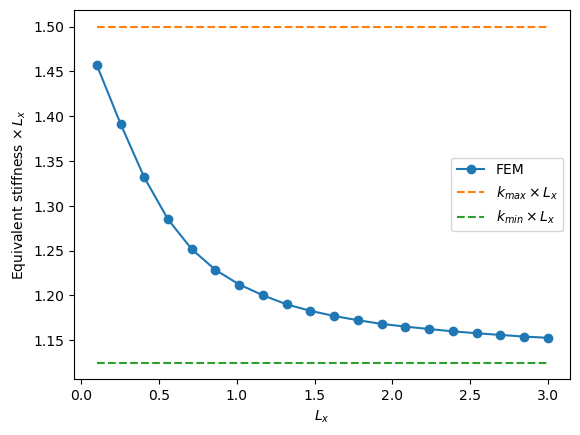

In [15]:
plt.plot(Ls,ks[:,0] * Ls ,'o-',label='FEM')

plt.plot(Ls,ks[:,2] * Ls,'--',label=r'$k_{max} \times L_x$')
plt.plot(Ls,ks[:,1] * Ls,'--',label=r'$k_{min} \times L_x $')
plt.xlabel(r'$L_x$')
plt.ylabel(r'Equivalent stiffness $\times \,L_x$')
plt.legend()